# Dublin Bikes Data Analysis

In [1]:
#import necessary libraries and files 
import pandas as pd
import numpy as np
import warnings
import time
import datetime as dt
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import folium
import sklearn
import seaborn as sns

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans


%matplotlib inline

In [2]:
# import functions to access the processed data
import useful as use

## Set the values of the variables below to what is required

db_location: the location on your computer of the wai.db file

start_date: the start date for which you would like to pull data

end_date: the end date for which you would like to pull data

station_id: the ID of the station that you are interested in. Set to 777 if you would like data for all stations returned

In [3]:
db_location = 'wai.db'
start_date = "2019-01-01"
end_date = "2021-10-01"
station_id = 777 # Set to 777 if you would like data for all stations returned

## Get the required data

In [4]:
conn = use.create_connection(db_file=db_location)

In [5]:
data = use.get_required_data(conn, start_date, end_date, station_id)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24631974 entries, 0 to 24631973
Data columns (total 32 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   STATION ID             int64         
 1   AVAILABLE BIKE STANDS  int64         
 2   AVAILABLE BIKES        int64         
 3   DATETIME               datetime64[ns]
 4   DATE                   object        
 5   YEAR                   int64         
 6   MONTH                  int64         
 7   DAY_NUMBER             int64         
 8   HOUR                   int64         
 9   MINUTE                 int64         
 10  OCCUPANCY_PCT          object        
 11  FULL                   int64         
 12  EMPTY                  int64         
 13  BIKE_ARR_DEP           float64       
 14  ACTIVITY_TYPE          object        
 15  IMBALANCED             int64         
 16  BIKE STANDS            int64         
 17  NAME                   object        
 18  ADDRESS             

## Feature engineering

#### Bucket days of the week and time

In [7]:
# weekday/saturday/sunday
data['DAY_TYPE'] = np.where(data['DAY_NUMBER'] <= 4, 'Weekday', (np.where(data['DAY_NUMBER'] == 5, 'Saturday', 'Sunday')))

# bucket time
def bin_time(x):
    if x.time() < dt.time(6):
        return "Overnight "
    elif x.time() < dt.time(11):
        return "6AM-10AM "
    elif x.time() < dt.time(16):
        return "11AM-3PM "
    elif x.time() < dt.time(20):
        return "4PM-7PM "
    elif x.time() <= dt.time(23):
        return "8PM-11PM "
    else:
        return "Overnight "

data["TIME_TYPE"] = data['DATETIME'].apply(bin_time)
data['CLUSTER_GROUP'] = data['TIME_TYPE'] + data['DAY_TYPE']

data.sample(5)

,STATION ID,AVAILABLE BIKE STANDS,AVAILABLE BIKES,DATETIME,DATE,YEAR,MONTH,DAY_NUMBER,HOUR,MINUTE,...,vappr,rhum,msl,wdsp,wddir,sun,avg_rain_per_interval,DAY_TYPE,TIME_TYPE,CLUSTER_GROUP
17396264,89,30,10,2021-02-14 17:40:02,2021-02-14,2021,2,6,17,40,...,10.1,75,1004.5,12,200,0.1,0.0,Sunday,4PM-7PM,4PM-7PM Sunday
6039040,61,15,10,2019-10-23 04:40:02,2019-10-23,2019,10,2,4,40,...,10.5,78,1012.7,7,190,0.0,0.0,Weekday,Overnight,Overnight Weekday
5043736,94,39,1,2019-09-24 16:00:03,2019-09-24,2019,9,1,16,0,...,15.2,68,994.1,6,140,0.2,0.0,Weekday,4PM-7PM,4PM-7PM Weekday
1694087,69,15,25,2019-05-23 07:05:02,2019-05-23,2019,5,3,7,5,...,11.5,77,1016.2,3,250,0.0,0.0,Weekday,6AM-10AM,6AM-10AM Weekday
2955019,53,33,7,2019-07-20 12:15:03,2019-07-20,2019,7,5,12,15,...,12.5,64,1007.9,15,280,0.1,0.0,Saturday,11AM-3PM,11AM-3PM Saturday


### Bucket years for pre and post Covid

In [8]:
def C19(x):
    if x > 2019:
        return 0
    else:
        return 1
data["COVID_INDICATOR"] = data['YEAR'].apply(C19)

In [9]:
data.describe()

,STATION ID,AVAILABLE BIKE STANDS,AVAILABLE BIKES,YEAR,MONTH,DAY_NUMBER,HOUR,MINUTE,FULL,EMPTY,...,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,sun,avg_rain_per_interval,COVID_INDICATOR
count,2.463197e+07,2.463197e+07,2.463197e+07,2.463197e+07,2.463197e+07,2.463197e+07,2.463197e+07,2.463197e+07,2.463197e+07,2.463197e+07,...,2.463197e+07,2.463197e+07,2.463197e+07,2.463197e+07,2.463197e+07,2.463197e+07,2.463197e+07,2.463197e+07,2.463197e+07,2.463197e+07
mean,5.995283e+01,2.053015e+01,1.150146e+01,2.020037e+03,6.381809e+00,2.978333e+00,1.147258e+01,2.749875e+01,9.235119e-02,2.807453e-02,...,8.770079e+00,6.917732e+00,1.040460e+01,7.962732e+01,1.012837e+03,9.082102e+00,2.011049e+02,1.815674e-01,7.202834e-03,3.158159e-01
std,3.356792e+01,1.071198e+01,9.205653e+00,8.168741e-01,3.206300e+00,1.988926e+00,6.920186e+00,1.725933e+01,2.895211e-01,1.651858e-01,...,4.487433e+00,4.611452e+00,3.256146e+00,1.352246e+01,1.286077e+01,4.438620e+00,8.739117e+01,3.352773e-01,3.350590e-02,4.648400e-01
min,2.000000e+00,0.000000e+00,0.000000e+00,2.019000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-5.400000e+00,-7.500000e+00,3.500000e+00,2.100000e+01,9.664000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e+01,1.300000e+01,4.000000e+00,2.019000e+03,4.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,...,5.600000e+00,3.500000e+00,7.900000e+00,7.100000e+01,1.004300e+03,6.000000e+00,1.300000e+02,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.100000e+01,2.000000e+01,1.000000e+01,2.020000e+03,6.000000e+00,3.000000e+00,1.100000e+01,2.500000e+01,0.000000e+00,0.000000e+00,...,8.700000e+00,6.800000e+00,9.900000e+00,8.200000e+01,1.014600e+03,8.000000e+00,2.200000e+02,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.900000e+01,2.900000e+01,1.700000e+01,2.021000e+03,9.000000e+00,5.000000e+00,1.700000e+01,4.000000e+01,0.000000e+00,0.000000e+00,...,1.220000e+01,1.050000e+01,1.270000e+01,9.100000e+01,1.022000e+03,1.200000e+01,2.700000e+02,2.000000e-01,0.000000e+00,1.000000e+00
max,1.170000e+02,4.400000e+01,4.300000e+01,2.021000e+03,1.200000e+01,6.000000e+00,2.300000e+01,5.500000e+01,1.000000e+00,1.000000e+00,...,2.050000e+01,1.900000e+01,2.200000e+01,1.000000e+02,1.048000e+03,3.100000e+01,3.600000e+02,1.000000e+00,1.066667e+00,1.000000e+00


## Correlation checks

In [10]:
corr_matrix = data.corr()
print(corr_matrix)

                       STATION ID  AVAILABLE BIKE STANDS  AVAILABLE BIKES  \
STATION ID               1.000000               0.309506         0.113476   
AVAILABLE BIKE STANDS    0.309506               1.000000        -0.714672   
AVAILABLE BIKES          0.113476              -0.714672         1.000000   
YEAR                     0.015095               0.005052        -0.004612   
MONTH                   -0.004092              -0.037724         0.041956   
DAY_NUMBER               0.000313              -0.007034         0.009734   
HOUR                     0.000020               0.011946        -0.013032   
MINUTE                   0.000003               0.000656        -0.000771   
FULL                    -0.027868               0.309865        -0.398530   
EMPTY                   -0.000896              -0.325733         0.341517   
BIKE_ARR_DEP             0.000046               0.038201        -0.043639   
IMBALANCED               0.007175               0.196953        -0.245181   

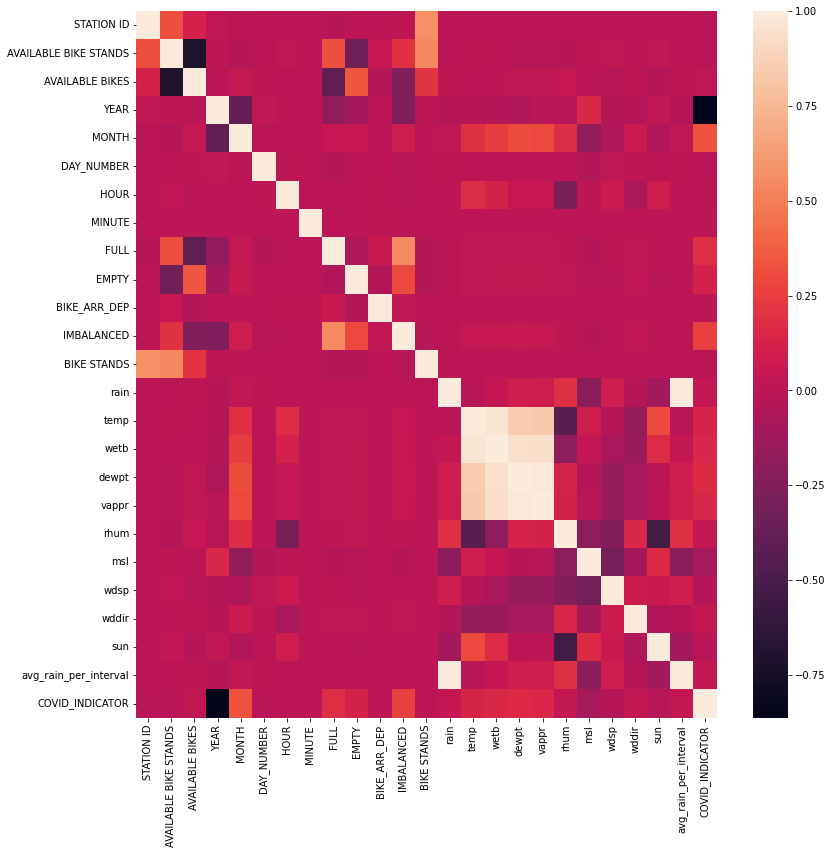

In [11]:
plt.rcParams['figure.figsize'] = [13, 13]
sns.heatmap(corr_matrix)
plt.show()

Is there an easier way to view the above?

In [12]:
def reformat_correlation_matrix(corr_mat, thresh, above=True):
    """
    Re-format the correlation matrix. 
    Drop any correlations of a variable with itself. Drop any remaining correlations that do
    not make the given threshold. Returning the remaining as a Pandas DataFrame
    
    corr_mat: Correlation matrix. The output of pandas.DataFrame.corr()
    thresh: Float. Value between -1 and 1. The threshold to use for filtering the correlation matrix
    above: Boolean. The direction / how we want to apply the threshold. True => return values
    above the given threshold. False => return values below the threshold
    """
    # TODO: Lots of room to improve the code in this function
    # Get the upper triangle:
    col_names = list(corr_matrix.columns)
    var1 = []
    var2 = []
    for ind in range(1, len(col_names)):
        for ind2 in range(ind, len(col_names)):
            var1.append(col_names[ind])
            var2.append(col_names[ind2])
    upper_triag_names = pd.DataFrame(data={'variable_1': var1, 'variable_2': var2})

    # Unstack
    ser = corr_mat.unstack()

    # Apply the threshold
    if above is True:
        tmp = ser[ser > thresh]
    else:
        tmp = ser[ser < thresh]

    # Drop any incident of a variable correlated with itself    
    drop = [0] * len(tmp)
    for ind in range(len(tmp)):
        if tmp.index[ind][0] == tmp.index[ind][1]:
            drop[ind] = 1

    tmp_df = tmp.to_frame()
    tmp_df['to_drop'] = drop
    final = tmp_df[tmp_df.to_drop == 0]

    # Some renaming of columns and re-setting the index
    final.columns = ['correlation_coefficient', 'to_drop']
    final = final[['correlation_coefficient']]
    final = final.reset_index()
    final = final.rename(columns={'level_0': 'variable_1', 'level_1': 'variable_2'})

    # Finally filter out any rows that are not found in the upper triangle
    final = final.merge(upper_triag_names)

    return final


In [13]:
positive_correlation = reformat_correlation_matrix(corr_mat=corr_matrix, thresh=0.75, above=True)
positive_correlation

,variable_1,variable_2,correlation_coefficient
0,rain,avg_rain_per_interval,1.000000
1,temp,wetb,0.969275
2,temp,dewpt,0.840881
3,temp,vappr,0.835375
4,wetb,dewpt,0.946331
5,wetb,vappr,0.938514
6,dewpt,vappr,0.987664


In [14]:
negative_correlation = reformat_correlation_matrix(corr_mat=corr_matrix, thresh=-0.85, above=False)
negative_correlation

,variable_1,variable_2,correlation_coefficient
0,YEAR,COVID_INDICATOR,-0.862509


## Visualisation of OCCUPANCY_PCT over a number of variables

In [15]:
data[['OCCUPANCY_PCT']].describe()

,OCCUPANCY_PCT
count,24631974.0
unique,562.0
top,0.0
freq,2274792.0


In [16]:
data[['OCCUPANCY_PCT']].dtypes

OCCUPANCY_PCT    object
dtype: object

OCCUPANCY_PCT should be a float with values ranging from 0 to 1.

In [17]:
data[data.OCCUPANCY_PCT== '']

,STATION ID,AVAILABLE BIKE STANDS,AVAILABLE BIKES,DATETIME,DATE,YEAR,MONTH,DAY_NUMBER,HOUR,MINUTE,...,rhum,msl,wdsp,wddir,sun,avg_rain_per_interval,DAY_TYPE,TIME_TYPE,CLUSTER_GROUP,COVID_INDICATOR
926516,35,0,0,2019-04-29 11:20:03,2019-04-29,2019,4,0,11,20,...,80,1023.7,10,130,0.0,0.0,Weekday,11AM-3PM,11AM-3PM Weekday,1
926628,35,0,0,2019-04-29 11:25:03,2019-04-29,2019,4,0,11,25,...,80,1023.7,10,130,0.0,0.0,Weekday,11AM-3PM,11AM-3PM Weekday,1
926740,35,0,0,2019-04-29 11:30:05,2019-04-29,2019,4,0,11,30,...,80,1023.7,10,130,0.0,0.0,Weekday,11AM-3PM,11AM-3PM Weekday,1
926852,35,0,0,2019-04-29 11:35:03,2019-04-29,2019,4,0,11,35,...,80,1023.7,10,130,0.0,0.0,Weekday,11AM-3PM,11AM-3PM Weekday,1
926964,35,0,0,2019-04-29 11:40:04,2019-04-29,2019,4,0,11,40,...,80,1023.7,10,130,0.0,0.0,Weekday,11AM-3PM,11AM-3PM Weekday,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24373706,10,0,0,2021-09-22 05:55:02,2021-09-22,2021,9,2,5,55,...,85,1027.4,7,240,0.0,0.0,Weekday,Overnight,Overnight Weekday,0
24373816,10,0,0,2021-09-22 06:00:02,2021-09-22,2021,9,2,6,0,...,81,1027.1,7,230,0.0,0.0,Weekday,6AM-10AM,6AM-10AM Weekday,0
24373926,10,0,0,2021-09-22 06:05:02,2021-09-22,2021,9,2,6,5,...,81,1027.1,7,230,0.0,0.0,Weekday,6AM-10AM,6AM-10AM Weekday,0
24374036,10,0,0,2021-09-22 06:10:02,2021-09-22,2021,9,2,6,10,...,81,1027.1,7,230,0.0,0.0,Weekday,6AM-10AM,6AM-10AM Weekday,0


It seems that OCCUPANCY_PCT is a blank string, '', when the available bike stands and the available bikes are both zero i.e. when the station is not in use.

OCCUPANCY_PCT is not applicable in these situations, therefore before we explore OCCUPANCY_PCT

In [18]:
df = data[data.OCCUPANCY_PCT != '']  # drop when there are no bikes and no stands available
df['OCCUPANCY_PCT'] = df['OCCUPANCY_PCT'].astype('float') # convert back to a float

# Sanity check
df[['OCCUPANCY_PCT']].describe()

,OCCUPANCY_PCT
count,2.462963e+07
mean,3.652701e-01
std,2.823269e-01
min,0.000000e+00
25%,1.315789e-01
50%,3.157895e-01
75%,5.500000e-01
max,1.000000e+00


### Boxplots

In [19]:
def explore_boxplots(df, var1, var2):
    """
    Use boxplots to explore how var2 change with different values of var1
    """
    tmp = df[[var1, var2]]
    f, ax = plt.subplots(figsize=(16, 8))
    fig = sns.boxplot(x=var1, y=var2, data=tmp)
    fig.axis(ymin=0, ymax=1)
    plt.xticks(rotation=90)
    

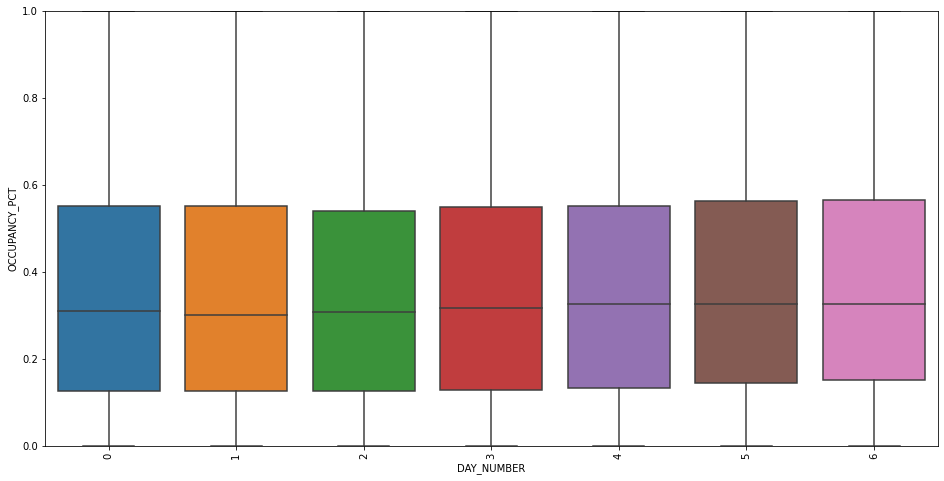

In [20]:
explore_boxplots(df, var1='DAY_NUMBER', var2='OCCUPANCY_PCT')

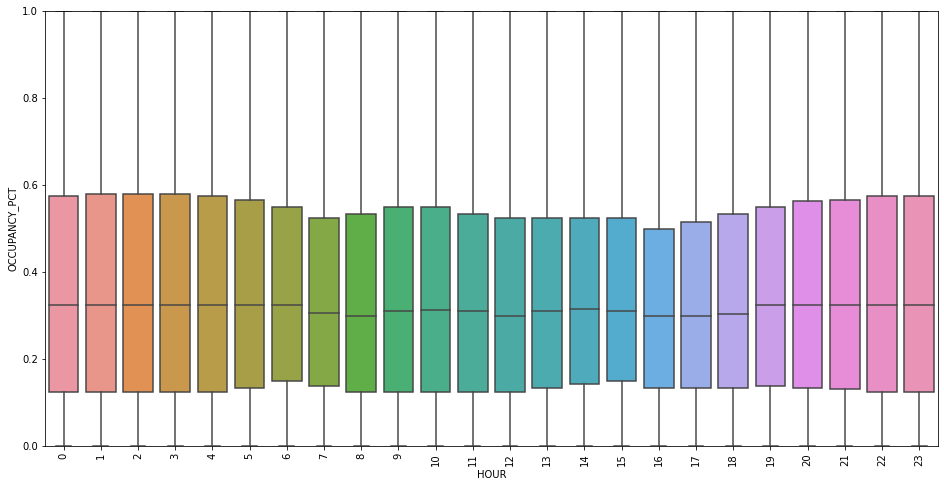

In [21]:
explore_boxplots(df, var1='HOUR', var2='OCCUPANCY_PCT')

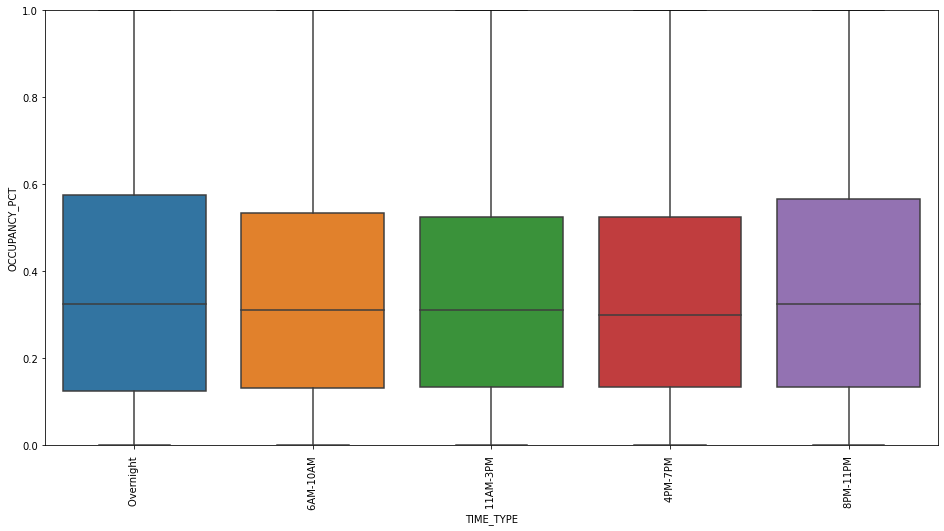

In [22]:
explore_boxplots(df, var1='TIME_TYPE', var2='OCCUPANCY_PCT')

Occupancy remains consistent between ~0.15 and ~0.6 across the day and across days of the week, suggesting that on a macro level bikes tend to be adequately balanced among stations


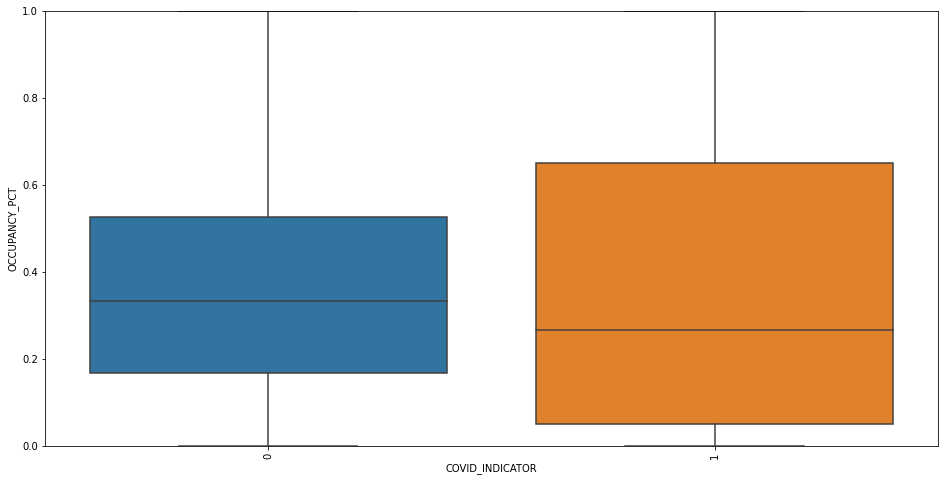

In [23]:
explore_boxplots(df, var1='COVID_INDICATOR', var2='OCCUPANCY_PCT')

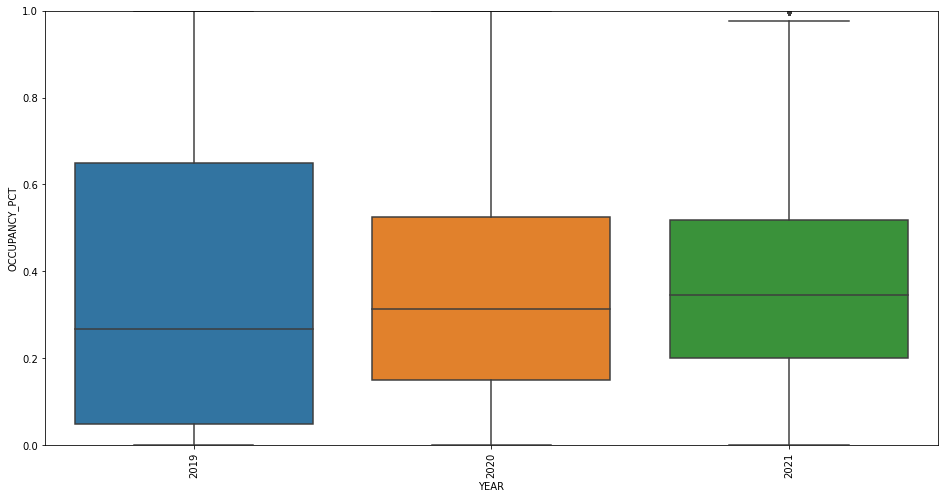

In [24]:
explore_boxplots(df, var1='YEAR', var2='OCCUPANCY_PCT')

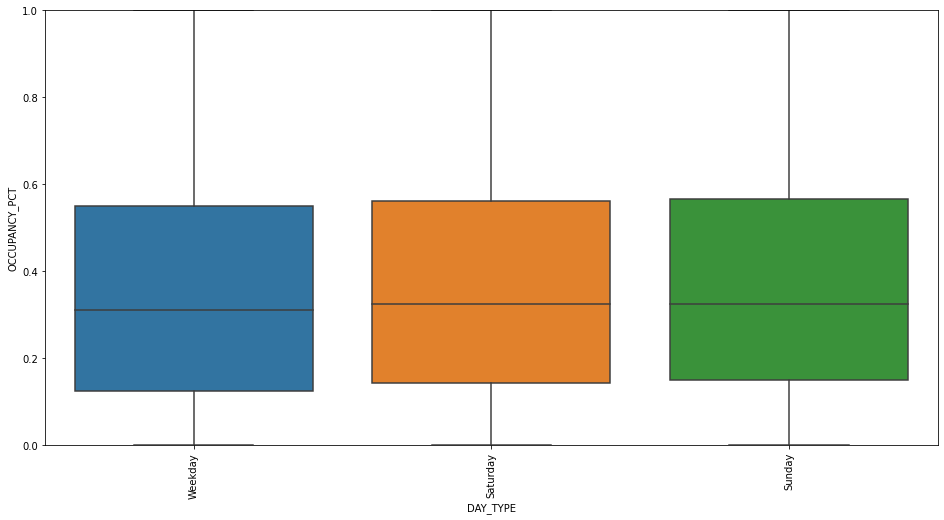

In [25]:
explore_boxplots(df, var1='DAY_TYPE', var2='OCCUPANCY_PCT')

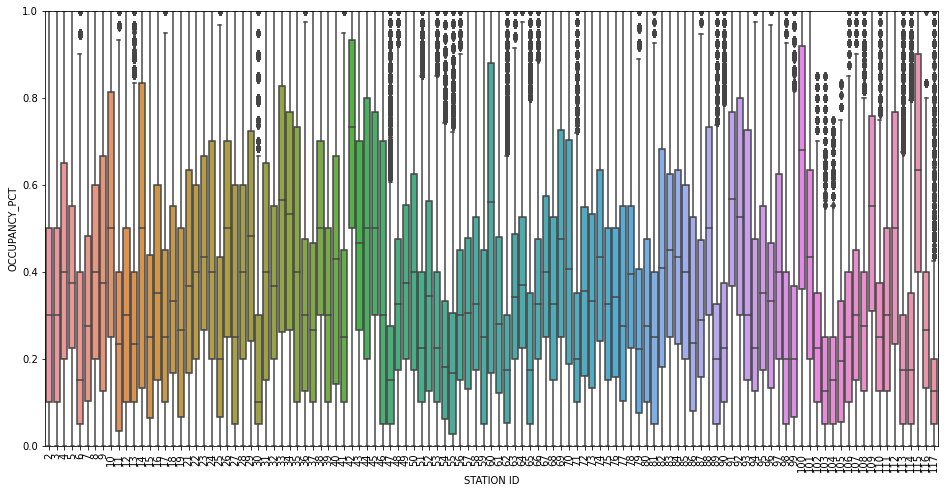

In [26]:
explore_boxplots(df, var1='STATION ID', var2='OCCUPANCY_PCT')

In [27]:
df.columns

Index(['STATION ID', 'AVAILABLE BIKE STANDS', 'AVAILABLE BIKES', 'DATETIME',
       'DATE', 'YEAR', 'MONTH', 'DAY_NUMBER', 'HOUR', 'MINUTE',
       'OCCUPANCY_PCT', 'FULL', 'EMPTY', 'BIKE_ARR_DEP', 'ACTIVITY_TYPE',
       'IMBALANCED', 'BIKE STANDS', 'NAME', 'ADDRESS', 'LATITUDE', 'LONGITUDE',
       'rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl', 'wdsp',
       'wddir', 'sun', 'avg_rain_per_interval', 'DAY_TYPE', 'TIME_TYPE',
       'CLUSTER_GROUP', 'COVID_INDICATOR'],
      dtype='object')

In [ ]:
# Modelling